# Annotated_Transformer_English_to_Chinese_Translator

```python
Created on   :2020/09/19 23:27:28
@author      :Caihao (Chris) Cui
@file        :Annotated_Transformer_English_to_Chinese_Translator.ipynb
@content     :Transformer English-to-Chinese.
@version     :0.1.0
```


In this notebook, I will build a Transformer model (neural network model) to translate English sentence to Chinese sentences.

The reference paper is [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

![](document/images/google_translate.png )

The full data set only contains around 10,000 sentence pairs. But this is very good practice to imporve your python programming skills and get deeper understanding of pytorch and Transformaer(neural networks).

![Attention Is All You Need](document/images/google_paper.png)

## 1. Understand the Transformer Model
 
The Whole Transformer  encoder-decoder model architecture  services for the following purposes. 


- Encoder(s): the encoding process transforms the input sentence (list of English words) into numeric matrix format (embedding ), consider this step is to extract useful and necessary information for the decoder. In Fig 06, the embedding is represented by the green matrix.

- Decoder(s): then the decoding process mapping these embeddings back to another language sequence as Fig 06 shown, which helps us to solve all kinds of supervised NLP tasks, like machine translation (in this blog), sentiment classification, entity recognition,  summary generation, semantic relation extraction and so on. 
 
![Understand_How_Transformer_Work](./document/images/Understand_How_Transformer_Work.png)

 

## 2. Encoder 
  
We will focus on the structure of the encoder in this section, because after understanding the structure of the encoder, understanding the decoder will be very simple. Moreover we can just use the encoder to complete some of the mainstream tasks in NLP, such as sentiment classification, semantic relationship analysis, named entity recognition and so on.

Recall that the Encoder denotes the process of mapping natural language sequences to mathematical expressions to hidden layers outputs.

**Here is a Transformer Encoder Block structure**
> Notification: the following sections will refer to the 1,2,3,4 blocks.

![Transformer Encoder Stacks](./document/images/encoder.png)

### 2.0 Data Preparation: English-to-Chinese Translator Data

In [1]:
!tree data/nmt/en-cn 

�ļ��� PATH �б�
�����к�Ϊ 8E30-BECB
C:\USERS\DEEP\DOCUMENTS\GITHUB\ANNOTATED-TRANSFORMER-ENGLISH-TO-CHINESE-TRANSLATOR\DATA\NMT\EN-CN
û�����ļ��� 



In [1]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# init parameters
UNK = 0  # unknow word-id
PAD = 1  # padding word-id
BATCH_SIZE = 64   

DEBUG = True    # Debug / Learning Purposes. 
# DEBUG = False # Build the model, better with GPU CUDA enabled.

if DEBUG:        
    EPOCHS  = 2   
    LAYERS  = 3   
    H_NUM   = 8    
    D_MODEL = 128   
    D_FF    = 256      
    DROPOUT = 0.1   
    MAX_LENGTH = 60   
    TRAIN_FILE = ''   
    DEV_FILE   = 'data/nmt/en-cn/dev_mini.txt'   
    SAVE_FILE  = 'save/models/model.pt'   
else:
    EPOCHS  = 20  
    LAYERS  = 6    
    H_NUM   = 8    
    D_MODEL = 256    
    D_FF    = 1024   
    DROPOUT = 0.1    
    MAX_LENGTH = 60  
    TRAIN_FILE = 'data/nmt/en-cn/train.txt'   
    DEV_FILE   = 'data/nmt/en-cn/dev.txt'   
    SAVE_FILE  = 'save/models/large_model.pt'  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
def seq_padding(X, padding=0):
    """
    add padding to a batch data 
    """
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])    

class PrepareData:
    def __init__(self, train_file, dev_file):
        # 01. Read the data and tokenize
        self.train_en, self.train_cn = self.load_data(train_file)
        print(f'self.train_cn is {self.train_cn}')
        self.dev_en, self.dev_cn     = self.load_data(dev_file)

        # 02. build dictionary: English and Chinese
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)
        #print(f'self.cn_word_dict is {self.cn_word_dict}')
        #print(f'self.cn_index_dict is {self.cn_index_dict}')

        # 03. word to id by dictionary 
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn     = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)
        #print(f'03 self.train_cn is {self.train_cn}')
        # 04. batch + padding + mask
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data   = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)
        #print(f'04 self.train_data is {self.train_data}')

    def load_data(self, path):
        """
        Read English and Chinese Data 
        tokenize the sentence and add start/end marks(Begin of Sentence; End of Sentence)
        en = [['BOS', 'i', 'love', 'you', 'EOS'], 
              ['BOS', 'me', 'too', 'EOS'], ...]
        cn = [['BOS', '我', '爱', '你', 'EOS'], 
              ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip().split('\t') #数据集中 存在一个\t 将中英文分开。
                #print(line)
                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + word_tokenize(" ".join([w for w in line[1]])) + ["EOS"])
        return en, cn
    
    def build_dict(self, sentences, max_words = 50000):
        """
        sentences: list of word list 
        build dictonary as {key(word): value(id)}
        """
        word_count = Counter()
        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1

        ls = word_count.most_common(max_words) #返回一个list，其中以tuple的形式存储word 及 出现的次数 ('BOS', 10)
        #print(f'ls is {ls}')
        total_words = len(ls) + 2
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # inverted index: {key(id): value(word)}
        index_dict = {v: k for k, v in word_dict.items()}# 经典 k和v换顺序
        return word_dict, total_words, index_dict

    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        convert input/output word lists to id lists. 
        Use input word list length to sort, reduce padding.
        """
        length = len(en)
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        def len_argsort(seq):
            """
            get sorted index w.r.t length.
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        if sort: # update index
            sorted_index = len_argsort(out_en_ids) # English
            out_en_ids = [out_en_ids[id] for id in sorted_index]
            out_cn_ids = [out_cn_ids[id] for id in sorted_index]
        return out_en_ids, out_cn_ids

    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        get data into batches
        """
        idx_list = np.arange(0, len(en), batch_size)
        if shuffle:
            np.random.shuffle(idx_list)

        batch_indexs = []
        for idx in idx_list:
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
        
        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index]  
            batch_cn = [cn[index] for index in batch_index]
            #print(f'before batch_cn is {batch_cn}')
            # paddings: batch, batch_size, batch_MaxLength
            batch_cn = seq_padding(batch_cn)
            #print(f'after batch_cn is {batch_cn}')
            batch_en = seq_padding(batch_en)
            batches.append(Batch(batch_en, batch_cn)) 
            #!!! 'Batch' Class is called here but defined in later section.
        return batches

In [4]:
f = 'Anyone can do that.	任何人都可以做到。'
f.strip()

'Anyone can do that.\t任何人都可以做到。'

In [5]:
TRAIN_FILE = 'C:\\Users\\deep\\Documents\\GitHub\\Annotated-Transformer-English-to-Chinese-Translator\\data\\nmt\\en-cn\\train_mini_copy.txt'
TEST_FILE = 'C:\\Users\\deep\\Documents\\GitHub\\Annotated-Transformer-English-to-Chinese-Translator\\data\\nmt\\en-cn\\test_mini_copy.txt'
pre = PrepareData(TRAIN_FILE, TEST_FILE)
pre.train_cn

self.train_cn is [['BOS', '任', '何', '人', '都', '可', '以', '做', '到', '。', 'EOS'], ['BOS', '要', '不', '要', '要', '要', '要', '要', '要', '要', '再', '來', '一', '塊', '蛋', '糕', '？', 'EOS'], ['BOS', '他', '面', '有', '飢', '色', 'EOS'], ['BOS', '我', '不', '知', '道', '要', '按', '哪', '個', '按', '鈕', '。', 'EOS'], ['BOS', '他', '從', '收', '音', '機', '聽', '到', '了', '這', '個', '消', '息', '。', 'EOS'], ['BOS', '不', '要', '讓', '水', '一', '直', '流', '。', 'EOS'], ['BOS', '我', '反', '對', '任', '何', '形', '式', '的', '戰', '爭', '。', 'EOS'], ['BOS', '我', '过', '了', '难', '挨', '的', '一', '天', '。', 'EOS'], ['BOS', '我', '反', '對', '任', '何', '形', '式', '的', '戰', '爭', '。', 'EOS'], ['BOS', '我', '过', '了', '难', '挨', '的', '一', '天', '。', 'EOS']]


NameError: name 'Batch' is not defined

> Notification, the Batch class relates to the Attention/Mask in Encoder class. 

#### Input/Output Embeddings
Similary to all sequential model, we used learned embedding to convert the input/output vectors' dimensionality to $d_{model}$.
In our model, the two embedding layers and pre-softmax layer will share weight matrix.

In [6]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__() 
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # return x's embedding vector（times math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model) / math.sqrt(self.d_model)

In [7]:
emb = Embeddings(4,4)
print(emb(torch.tensor([1])))
print(emb(torch.tensor([2])))
for i,j in emb.named_parameters():
    print(j)

tensor([[-0.4753, -0.9500, -0.5614,  0.4227]], grad_fn=<DivBackward0>)
tensor([[-0.1462,  0.1251,  0.2873, -0.0785]], grad_fn=<DivBackward0>)
Parameter containing:
tensor([[ 1.9912, -1.0384, -1.2706, -1.4884],
        [-0.4753, -0.9500, -0.5614,  0.4227],
        [-0.1462,  0.1251,  0.2873, -0.0785],
        [-0.5159, -1.3545,  0.7540,  0.3610]], requires_grad=True)


In [8]:
0.2174 /  0.1537 ,0.9649 /  0.6823,-0.9677/-0.6843,-1.4577/-1.0307

(1.4144437215354586,
 1.4141873076359373,
 1.4141458424667543,
 1.4142815562239255)

Now, we have all the code for data preprocessing. Let's focus on the understand and build Transformer mode. 

### 2.1 Positional Encoding

The $Transformer$ does **not** contain iteration operation like RNN or LSTM in encoders, so we have to offer the position information of the words to the model, so the model learns the order in the input sequence.  

Thus, we define the **positional encoding** as [max_sequence_length, embedding_dimension]

In the paper, we use sine and cosine function to provide the position information.

$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \quad \quad PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})\tag{eq.1}$$  

In [9]:
DEVICE = 'cuda'
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
                                  
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        #print(f'001 pe is {pe}')
        position = torch.arange(0., max_len, device=DEVICE).unsqueeze(1)
        #print(f'002 positon is {position}')
        div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
        #print(f'03 div_term is {div_term}')
        pe_pos   = torch.mul(position, div_term)
        #print(f'04 pe_pos is {pe_pos}')
        pe[:, 0::2] = torch.sin(pe_pos)
        pe[:, 1::2] = torch.cos(pe_pos)
        pe = pe.unsqueeze(0) 
        #print(f'pe is {pe}')
                                  
        self.register_buffer('pe', pe) # pe

    def forward(self, x):
        #  build pe w.r.t to the max_length
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

See, we first build the position encoding based on x and then add the 'pe' to the x in the forward function.

> Notification: Set 'requires_grad=False'，because we do not need to train pe.

Here are the position embedding visualisations, you can find the pattern changes with the increasing embedding dimensions. 

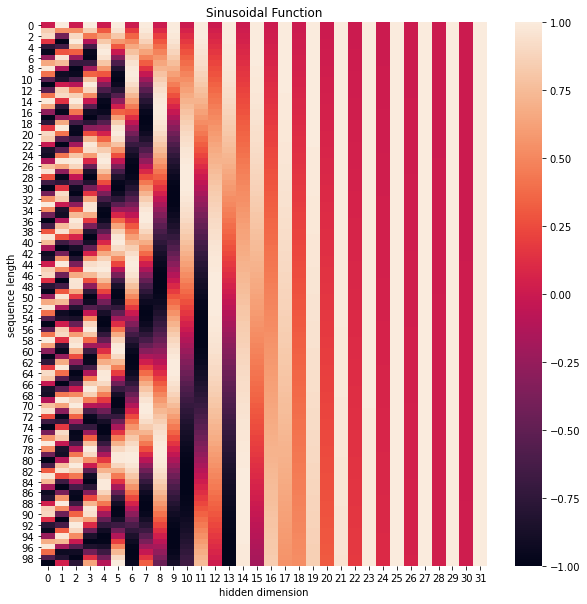

In [10]:
pe = PositionalEncoding(32, 0, 100)  # d_model, dropout-ratio, max_len
positional_encoding = pe.forward(Variable(torch.zeros(1, 100, 32).to('cuda'))) # sequence length, d_model
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding.squeeze().to('cpu')) # 100x32 matrix
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")
None

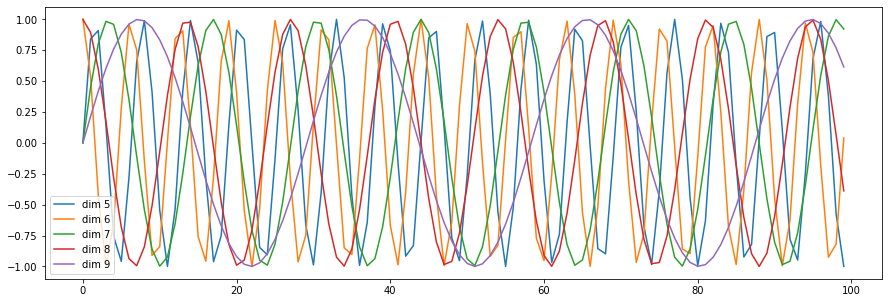

In [11]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(24, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 24).to('cuda')))
plt.plot(np.arange(100), y[0, :, 0:5].to('cpu').data.numpy())
plt.legend(["dim %d"%p for p in [5,6,7,8,9]])
None

### 2.2 Self Attention and Mask

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. 

We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

![self_attention](document/images/self-attention.png)


 The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$
. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0  and variance 1 . Then their dot product, $q\cdot k $ has mean 0 and variance $d_k$,To counteract this effect, we scale the dot products by  $\frac{1}{\sqrt{d_k}}$.

- 我们求的是，k和q的点积，可以用余弦相似度去理解。相似度越大，则两个相似度越高。反之如果相似度为0，则表示他们正交，没有相似度。
- 为什么要除以$\sqrt{d_k}$？计算相似度有两种方式，一种是加法注意力机制，一种是点乘注意力机制，我们这种属于点乘。scaled就是对注意力权重进行缩放，用来确保数值的稳定性。


In [79]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) 
    #d_k = 256
    print(f'd_k is {d_k}')
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)#为什么要除以这个dk的平方根
    print(f'scores is {scores}')
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    print(f'score is {scores}')
    
    p_attn = F.softmax(scores, dim=-1)#dim = -1 mean dim = 2 也就是按照最后一个维度来计算，最后一个维度是列，因此就每一列取一个数来计算 softmax。
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [86]:
q = torch.tensor([1,1,1,2,2,2],dtype=torch.float32).reshape(1,2,-1)
k = q
q.shape,k.shape
print(torch.tensor([0.0,0.0,1.0,1.0]).reshape(1,2,-1))
attention(q,k,q,mask=torch.tensor([1.0,0.0,0.0,1.0]).reshape(1,2,-1))

tensor([[[0., 0.],
         [1., 1.]]])
d_k is 3
scores is tensor([[[1.7321, 3.4641],
         [3.4641, 6.9282]]])
score is tensor([[[ 1.7321e+00, -1.0000e+09],
         [-1.0000e+09,  6.9282e+00]]])


(tensor([[[1., 1., 1.],
          [2., 2., 2.]]]),
 tensor([[[1., 0.],
          [0., 1.]]]))

In [82]:
mask=torch.zeros(1,1,1)
mask

tensor([[[0.]]])

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

In [46]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # check the h number
        self.d_k = d_model // h
        self.h = h
        # 4 linear layers: WQ WK WV and final linear mapping WO  
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0) # get batch size
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # parttion into h sections，switch 2,3 axis for computation. 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # final linear layer

In [74]:
linears = clones(nn.Linear(9, 9), 4)
#for i,j in linears.named_parameters():
 #   print(i,j)
q = torch.tensor([1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6],dtype=torch.float32).reshape(1,2,-1)
#print(q.shape)
k = v = -q
for l, x in zip(linears, (q, k, v)):
    print(l,x)

l(x).view(1,-1,3,3).transpose(1, 2) ,l(x)

Linear(in_features=9, out_features=9, bias=True) tensor([[[1., 1., 1., 2., 2., 2., 3., 3., 3.],
         [4., 4., 4., 5., 5., 5., 6., 6., 6.]]])
Linear(in_features=9, out_features=9, bias=True) tensor([[[-1., -1., -1., -2., -2., -2., -3., -3., -3.],
         [-4., -4., -4., -5., -5., -5., -6., -6., -6.]]])
Linear(in_features=9, out_features=9, bias=True) tensor([[[-1., -1., -1., -2., -2., -2., -3., -3., -3.],
         [-4., -4., -4., -5., -5., -5., -6., -6., -6.]]])


(tensor([[[[ 1.1221, -0.1844, -0.6499],
           [ 2.7562,  0.4769, -0.8850]],
 
          [[-1.6729,  2.8146,  2.7129],
           [-4.0999,  6.4062,  5.8230]],
 
          [[-1.6931,  0.8112, -2.3861],
           [-3.6033,  2.6506, -4.9977]]]], grad_fn=<TransposeBackward0>),
 tensor([[[ 1.1221, -0.1844, -0.6499, -1.6729,  2.8146,  2.7129, -1.6931,
            0.8112, -2.3861],
          [ 2.7562,  0.4769, -0.8850, -4.0999,  6.4062,  5.8230, -3.6033,
            2.6506, -4.9977]]], grad_fn=<ViewBackward0>))

**Attention Mask**

The input $X$ is $[batch-size,  sequence-length]$, we use 'padding' to fill the matrix with 0 with respect to the longest sequence. 

But this will case issues for the softmax computation. 
$\sigma(\mathbf {z})_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}$, where $e^0=1$.

This means the padding sections join the computation, but they shouldn't. So we create this mask to ignore these area by assign a large negative bias.
 
$$z_{illegal} = z_{illegal} + bias_{illegal}$$
$$bias_{illegal} \to -\infty$$
$$e^{z_{illegal}} \to 0 $$  
  
Thus, the masked area will lead to 0 so we avoid them in computation.

> Notification: in self-attention compution, we use mini-batch data as input, means we feed multiply lines of sentences into the model for training and computation. 


![](document/images/attention_mask.png)

In Transformer, both encoder and decoder attention computations need masking operation, but their functions are different.

In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to '-inf') before the softmax step in the self-attention calculation.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.
  
Here, we define a batch object that holds the src (English) and target sentences (Chinese) for training, as well as constructing the masks.

> Notification: Mask(Opt.) is between Scale and Softmax
 

In [8]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # convert words id to long format.  
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # get the padding postion binary mask
        # change the matrix shape to  1×seq.length
        self.src_mask = (src != pad).unsqueeze(-2)
        # 如果输出目标不为空，则需要对decoder要使用到的target句子进行mask
        if trg is not None:
            # decoder input from target 
            self.trg = trg[:, :-1]
            # decoder target from trg 
            self.trg_y = trg[:, 1:]
            # add attention mask to decoder input  
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # check decoder output padding number
            self.ntokens = (self.trg_y != pad).data.sum()
    
    # Mask 
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask # subsequent_mask is defined in 'decoder' section.

### 2.3 Layer Normalization and Residual Connection

1). **LayerNorm**:   
  
**Layer Normalization** normalize the hidden layer output into standard format, i.i.d, to boost the training efficency and model weight convergence (row wise). 
$$\mu_{i}=\frac{1}{m} \sum^{m}_{i=1}x_{ij}$$  
  
$$\sigma^{2}_{j}=\frac{1}{m} \sum^{m}_{i=1}
(x_{ij}-\mu_{j})^{2}$$  
  
$$LayerNorm(x)=\alpha \odot \frac{x_{ij}-\mu_{i}}
{\sqrt{\sigma^{2}_{i}+\epsilon}} + \beta \tag{eq.5}$$  
  
$\epsilon$ is to avoid $0$ division; **$\alpha, \beta$** are parameter, $\odot$ denotes element-wise product. Normally, we initialize $\alpha$ as 1s and $\beta$ as 0s.

2). **Residual Connection**:   
 
We employ a residual connection  around each of the two sub-layers, followed by layer normalization.
We get the Value matrix with the weights from attenations $Attention(Q,  K, V)$, and then we 
transpose it to make sure it shares the same shape of $X_{embedding}:[batch.size, sequence.length, embedding.dimension]$. And then add them together.

$$X_{embedding} + Attention(Q, K, V)$$  
  
In the following compuations, after each module, we add the input with the output of the module to get residual connection, which allows the gradients be back-propogated to the start layers. 
$$X + SubLayer(X) \tag{eq. 6}$$  
  
> **Notification**: to $SubLayer(X)$ we call the dropout function and then add x, $X + Dropout(SubLayer(X))$

大家注意一个问题，我们之前听说的都是batchnorm，现在讲的是layer norm。batch norm 相当于过来一批照片 比如64张 每个通道有三个 那么是将每个通道的64张照片提取出来 计算mean和var 代码如下
- 有参数叫做 momentum 因为预测阶段没办法计算mean和var了，所以通过统计一个running var和mean 用于计算 这个涉及到了动量参数
- 其中有两个参数 γ和β是需要学习的。如果affline设置为false 那么这两个参数就不用学习了。


In [127]:
import math
p1 = torch.arange(12,dtype=torch.float32).reshape(1,3,2,2)
print(p1)
bn = torch.nn.BatchNorm2d(3,affine=False)
print(bn(p1))
print(bn.running_mean, bn.running_var,bn.weight,bn.bias)
print((0 - 1.5)/(math.sqrt(1.25 )))

a = np.array([0,1,2,3])
a.mean()
a.var()
1.0667/1.25

tensor([[[[ 0.,  1.],
          [ 2.,  3.]],

         [[ 4.,  5.],
          [ 6.,  7.]],

         [[ 8.,  9.],
          [10., 11.]]]])
tensor([[[[-1.3416, -0.4472],
          [ 0.4472,  1.3416]],

         [[-1.3416, -0.4472],
          [ 0.4472,  1.3416]],

         [[-1.3416, -0.4472],
          [ 0.4472,  1.3416]]]])
tensor([0.1500, 0.5500, 0.9500]) tensor([1.0667, 1.0667, 1.0667]) None None
-1.3416407864998738


0.85336

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # rows
        std = x.std(-1, keepdim=True)
        x_zscore = (x - mean)/ torch.sqrt(std ** 2 + self.eps) 
        return self.a_2*x_zscore+self.b_2 

In [150]:
### 举例子说明 torch当中的norm是个什么东西 所以真实的layernormal 或者说torch当中的实现 和我们想的还是有些区别的，他是对一个token上的所有维度求mean和var
t = torch.arange(24,dtype=torch.float32).reshape(3,2,4)
print(t)
layer_norm = torch.nn.LayerNorm(4)
out = layer_norm(t)
print(out)
a = np.arange(4,8)
print(a.mean(),a.std())
(4-5.5) / 1.1180340


tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.]],

        [[ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.]]])
tensor([[[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]],

        [[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]],

        [[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]]],
       grad_fn=<NativeLayerNormBackward0>)
5.5 1.118033988749895


-1.3416407729997477

PyTorch has nn.LayerNorm，but we apply math equations here to learn. 

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    SublayerConnection: connect Multi-Head Attention and Feed Forward Layers 
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### 2.4 Feedforwad Networks 
**Position-wise Feed-Forward Networks**

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$ FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.

The dimensionality of input and output is $d_{model}$, and the inner-layer has dimensionality $d_{ff}$.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = self.w_1(x)
        h2 = self.dropout(h1)
        return self.w_2(h2)

### 2.5 Transformer Encoder Overview

Now, we have programmed the four parts of the Transformer Encoder. Let us review how the data are transformed through all these layers.

1. **Word Embedding and Positional Encoding**:

$$X = EmbeddingLookup(X) + PositionalEncoding(X)$$

$$X \in \mathbb{R}^{batch.size \times  seq.len.\times   embed.dim.} $$  
  
2. **Self-Attention and Mask**:

$$Q = Linear(X) = XW_{Q}$$ 
$$K = Linear(X) = XW_{K}$$
$$V = Linear(X) = XW_{V}$$
$$X_{attention} = SelfAttention(Q, K, V)$$  

3. **Residual Connection and Layer Normalization**:

$$X_{attention} = LayerNorm(X_{attention})$$
$$X_{attention} = X + X_{attention} $$  

4. **Position-wise Feed-Forward Networks** two linear mappings with ReLU Avtivation function:
$$X_{hidden} = Linear(Activate(Linear(X_{attention})))$$  
  
5. **Repeat 3** :
$$X_{hidden} = LayerNorm(X_{hidden})$$
$$X_{hidden} = X_{attention} + X_{hidden}$$

$$X_{hidden} \in \mathbb{R}^{batch.size \times  seq.len.\times   embed.dim.}$$  
  

In [47]:
def clones(module, N):
    """
    "Produce N identical layers."
    Use deepcopy the weight are indenpendent.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [48]:
linears = clones(nn.Linear(3, 3), 4)
linears

ModuleList(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): Linear(in_features=3, out_features=3, bias=True)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): Linear(in_features=3, out_features=3, bias=True)
)

In the paper, $Encoder$ has $N=6$ blocks.

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers (blocks)"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn.
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Each **Encoder Block** contains two sub-layers(**Self-Attention**,**Position-wise**) and 2 sublayer-connetions:
 

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size # d_model

    def forward(self, x, mask):
        # X-embedding to Multi-head-Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # X-embedding to feed-forwad nn
        return self.sublayer[1](x, self.feed_forward)

## 3.  Decoder

After the introduction of the encoder structure, we can see the decoder shares a lot similarities of encoder.
It also stacks N times. But there is a Encoder-Deconder-Contex-Attention layer (sublayer[1]) between the Masked MHA[0] and FFN[2]. It use the output of the decoder as query to search the output of encoder with MHA, which makes decoder see all the outputs from encoder.

Decoding process:
- Input: Encoding output(memory) and i-1 position decoder output/
- Output: i position output work probabilities.
- decoding process works like RNN.

![Decoder Structure](document/images/decoder.png)

In [9]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        "Generic N layer decoder with masking."
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Repeat decoder N times
        Decoderlayer get a input attention mask (src) 
        and a output attention mask (tgt) + subsequent mask 
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # encoder output embedding
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # Context-Attention：q=decoder hidden，k,v from encoder hidden
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking (**subsequent_mask**), combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i .


For Encoder src-mask, just mask the padding cells. 
But for decoder trg-mask, we need mask the padding and add the subsequent-mask process.  

In [161]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    print(subsequent_mask)
    return torch.from_numpy(subsequent_mask) == 0

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.
"Yellow" color denote True.

[[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]]


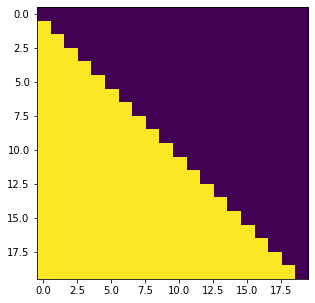

In [162]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

## 4. Transformer Model
  
Finally, let us put encoder and decoder together with the 'generator'.

![](document/images/English-to-Chinese.png)

Recall the decoder then generates an output sequence, of symbols one element at a time. At each step the model is auto-regressive (cite), consuming the previously generated symbols as additional input when generating the next. 

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator 

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        # encoder output will be the decoder's memory for decoding
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [ ]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode: d_model to vocab mapping
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

**Set Parameters and Create the Full Transformer model Function**

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy
    #  Attention 
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    #  FeedForward 
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    #  Positional Encoding
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    #  Transformer 
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    # Paper title: Understanding the difficulty of training deep feedforward neural networks Xavier
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

## 5. Transformer Model Training: English-to-Chinese  

Regularization **Label Smoothing**

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ (https://arxiv.org/pdf/1512.00567.pdf). 

This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.
  
>We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum') # 2020 update
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

Here, 'size' is from vocab，'smoothing' is value to be distributed on non-groundtruth.
We can see an example of how the mass is distributed to the words based on confidence.

In [ ]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.1)  #  ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

In [ ]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

**Loss Computation**

In [ ]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

**Optimizer with Warmup Learning Rate**

According to the paper, they applied a warmup learning rate with Adam Optimizer with $\beta_1=0.9、\beta_2=0.98$ 和 $\epsilon = 10^{−9}$.  

This will update the learning rate over the course of training, according to the formula:

$$lrate = d^{−0.5}_{model}⋅min(step\_num^{−0.5},\; step\_num⋅warmup\_steps^{−1.5})$$  

This corresponds to increasing the learning rate linearly for the first "warmup_steps" training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
# We used factor=2, warmup-step = 4000
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

all the updates are for the learning rate, 
- model-size denotes $d_{model}$. 
- warmup denotes  warmup-steps.
- factor is a scalar.

Example of the curves of this model for different model sizes and for optimization hyperparameters.

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

**Training Iterators**

In [ ]:
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.
    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch {:d} Batch: {:d} Loss: {:.4f} Tokens per Sec: {:.2f}s".format(epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [ ]:
def train(data, model, criterion, optimizer):
    """
    Train and Save the model.
    """
    # init loss as a large value
    best_dev_loss = 1e5
    
    for epoch in range(EPOCHS):
        # Train model 
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # validate model on dev dataset
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: {:.2f}'.format(dev_loss))
        
        # save the model with best-dev-loss
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            torch.save(model.state_dict(), SAVE_FILE) # SAVE_FILE = 'save/model.pt'
            
        print(f">>>>> current best loss: {best_dev_loss}")

In [ ]:
# Step 1: Data Preprocessing
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print(f"src_vocab {src_vocab}")
print(f"tgt_vocab {tgt_vocab}")

# Step 2: Init model
model = make_model(
                    src_vocab, 
                    tgt_vocab, 
                    LAYERS, 
                    D_MODEL, 
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

# Step 3: Training model
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

## 6. Prediction with English-to-Chinese Translator

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Translate src with model
    """
    # decode the src 
    memory = model.encode(src, src_mask)
    # init 1×1 tensor as prediction，fill in ('BOS')id, type: (LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    #  run 遍历输出的长度下标
    for i in range(max_len-1):
        # decode one by one
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        #  out to log_softmax 
        prob = model.generator(out[:, -1])
        #  get the max-prob id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        #  concatnate with early predictions
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

English to Chinese Translations

In [ ]:
def evaluate(data, model):
    """
    Make prediction with trained model, and print results.
    """
    with torch.no_grad():
        #  pick some random sentences from dev data.         
        for i in np.random.randint(len(data.dev_en), size=10):
            # Print English sentence
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]])
            print("\n" + en_sent)
            
            # Print Target Chinese sentence
            cn_sent =  " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]])
            print("".join(cn_sent))
            
            # conver English to tensor  
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            src = src.unsqueeze(0)
            # set attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # apply model to decode, make prediction
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # save all in the translation list 
            translation = []
            # convert id to Chinese, skip 'BOS' 0.
            # 遍历翻译输出字符的下标（注意：跳过开始符"BOS"的索引 0）
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym != 'EOS':
                    translation.append(sym)
                else:
                    break
            print("translation: {}".format(" ".join(translation)))

**English to Chinese Translator** 

In [ ]:
# Predition
model.load_state_dict(torch.load(SAVE_FILE))
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)         
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

If your translation does not look good, that is totally OK. 
You can change the “Debug“ to False and retrain the model with CUDA support.

In [ ]:
# Here is my pretrained model with CUDA support 
if DEVICE=="cuda":
    SAVE_FILE_EXTRA  = 'save/models/large_model.pt'  
    model.load_state_dict(torch.load(SAVE_FILE_EXTRA))
    print(">>>>>>> start evaluate")
    evaluate_start  = time.time()
    evaluate(data, model)         
    print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

## Reference

- The Annotated Transformer http://nlp.seas.harvard.edu/2018/04/03/attention.html
- The Illustrated Transformer http://jalammar.github.io/illustrated-transformer/
- GreedAI NLP Training Camp: https://www.greedyai.com/ 


THE END